# Robotics and Machine Vision – Image Warping Lab

Last edited by Nadejda Roubtsova for September - October 2024 

This lab will explore image warping.

You should download the **supporting images** `mona.jpg` and `windows.jpg` from the assignment's webpage, and put them into the same directory as this notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Make figures larger.
plt.rcParams['figure.figsize'] = [10, 6]

## Try commenting this out if plots look blurry on your screen.
# %config InlineBackend.figure_format = 'retina'


## 1. Forward mapping [15 marks]

Let us start by implementing image warping using forward mapping.
Every pixel in the source image is transformed to the target image independently. You will see that this approach leads to gaps between the transformed pixels in the target image.



Let's first load the image and define an example warping transformation for this assignment:

In [3]:
source = plt.imread('mona.jpg') / 255.

## Basic transformations to manipulate the source image.
T = np.array([[1, 0, -source.shape[1] / 2],
              [0, 1, -source.shape[0] / 2],
              [0, 0, 1]])
t = np.pi / 4
R = np.array([[np.cos(t), -np.sin(t), 0],
              [np.sin(t),  np.cos(t), 0],
              [ 0, 0, 1]])
S = np.diag([2, 2, 1])

## The warping transformation (rotation about arbitrary point).
M = np.linalg.inv(T) @ R @ S @ T

<span style="color:red"> **For you to do:** </span>

**a) Implement a function to transform a point (x, y) using a homogeneous 2D transform matrix, rounding to the nearest pixel. [5 marks]**

In [4]:
def transform_pixel_nn(x_coord, y_coord, transform_matrix):
    """Transforms a source pixel coordinate (x, y) using 'transform', and rounds to the nearest pixel
    coordinate. Returns a tuple (x', y')."""
    # Create homogeneous coordinate vector from input coordinates
    homog_vector = np.array([x_coord, y_coord, 1.0], dtype=float)
    
    # Perform matrix multiplication to apply transformation
    new_x, new_y, homog_factor = transform_matrix @ homog_vector
    
    # Normalise coordinates by dividing by homogeneous factor if non-zero
    if homog_factor != 0:
        new_x /= homog_factor
        new_y /= homog_factor
    
    # Round transformed coordinates to nearest integer pixel position
    return (int(round(new_x)), int(round(new_y)))

<span style="color:red"> **For you to do:** </span>

**b) Implement forward mapping using your per-pixel transform function. The pixel grid is meant to be kept consistent between the source and target. [10 marks]**

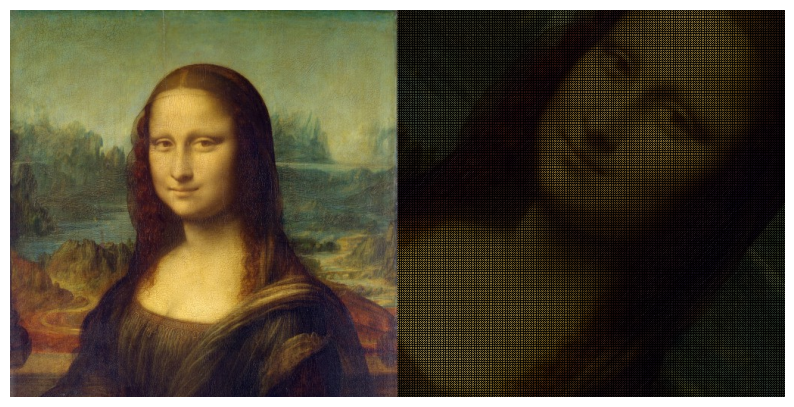

In [8]:
def forward_mapping(source: np.ndarray, M: np.ndarray) -> np.ndarray:

    height, width = source.shape[:2]

    # Create blank target image
    target = np.zeros_like(source)

    # Generate homogeneous coordinate grid for source pixels
    y_coords, x_coords = np.indices((height, width))
    ones_array = np.ones_like(x_coords)
    source_homog = np.stack([x_coords, y_coords, ones_array], axis=0).reshape(3, -1)

    # Transform coordinates
    dest_homog = M @ source_homog
    dest_homog /= dest_homog[2] + 1e-12
    target_x = np.round(dest_homog[0]).astype(int)
    target_y = np.round(dest_homog[1]).astype(int)

    # Filter coordinates within image bounds
    valid_mask = (0 <= target_x) & (target_x < width) & (0 <= target_y) & (target_y < height)

    # Transfer pixel values
    if source.ndim == 2:
        target[target_y[valid_mask], target_x[valid_mask]] = source.reshape(-1)[valid_mask]
    else:
        target[target_y[valid_mask], target_x[valid_mask]] = source.reshape(-1, source.shape[2])[valid_mask]

    return target

## Display original and transformed images
target = forward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");


## 2. Backward mapping [20 marks]

<span style="color:red"> **For you to do:** </span>

**a) Using the `transform_pixel_nn` function from your implementation of forward mapping implement backward mapping in the code cell below using the same 2D transformation `M`.**

Backward mapping computes for each **target image pixel** where in the source image it originats from, and, in its simplest form, uses the colour sampled from the nearest pixel. Note that this operation should not leave any gaps in the warped image.

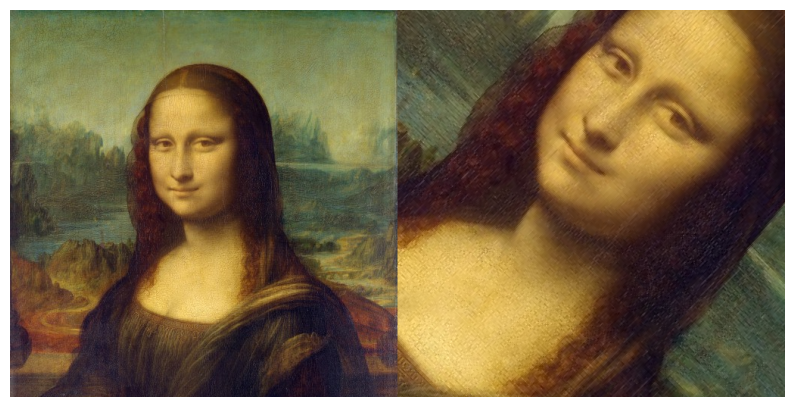

In [9]:
def backward_mapping(source_image: np.ndarray, transform_matrix: np.ndarray) -> np.ndarray:

    image_height, image_width = source_image.shape[:2]

    # Create empty target image
    target_image = np.zeros_like(source_image)

    # Calculate inverse transformation matrix
    inverse_matrix = np.linalg.inv(transform_matrix)

    # Generate coordinate grid for target pixels
    y_coordinates, x_coordinates = np.indices((image_height, image_width))

    # Convert to homogeneous coordinates
    target_homog = np.stack([x_coordinates.ravel(),
                                 y_coordinates.ravel(),
                                 np.ones_like(x_coordinates).ravel()])

    # Transform coordinates back to source space
    source_homog = inverse_matrix @ target_homog
    source_homog /= source_homog[2]

    # Calculate nearest pixel positions
    source_x = np.rint(source_homog[0]).astype(int)
    source_y = np.rint(source_homog[1]).astype(int)

    # Filter valid coordinates within image boundaries
    valid_coordinates = (0 <= source_x) & (source_x < image_width) & (0 <= source_y) & (source_y < image_height)

    # Transfer pixel values to target image
    if source_image.ndim == 2:
        target_image.flat[valid_coordinates] = source_image[source_y[valid_coordinates], source_x[valid_coordinates]]
    else:
        target_image.reshape(-1, source_image.shape[2])[valid_coordinates] = \
            source_image[source_y[valid_coordinates], source_x[valid_coordinates]]

    return target_image

## Visualise input (left) and warped output (right).
target = backward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");

## 3. Linear interpolation [20 marks]

<span style="color:red"> **For you to do:** </span>

**a) In the code cell below, modify your backward mapping function from part 2 to sample pixel colours from the source image using bilinear interpolation. [15 marks]**

**b) Handle the edge cases carefully for full marks. Specifically, implement the "fading to black" effect at the edges of the interpolated image by carefully considering how to handle the off-the-image grid pixels of the source image during interpolation. [5 marks]**

**Hint:** For validation, it may be helpful to use the transformations `M` commented out in the code cell below.

Interpolation must be implemented from scratch, not using any exisiting library functions. Note that interpolation may require a different precision of mapping and/or rounding approach to anchor to the pixel grid. So, in this question, feel free **not** to use `transform_pixel_nn` from Q1 a), which rounds off to the nearest pixel, or to write a *modified* version of the function.

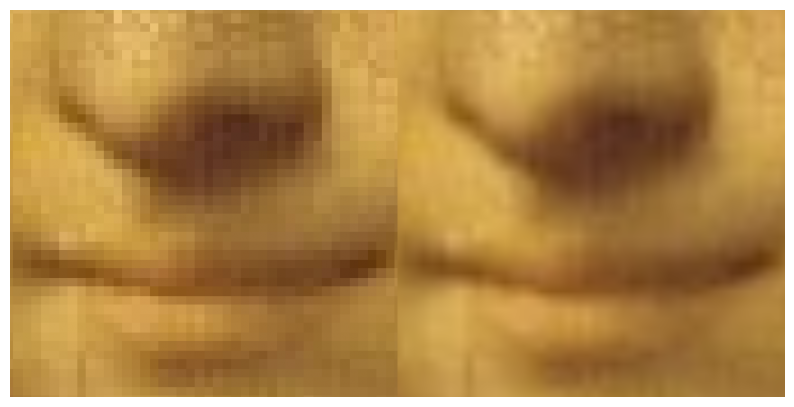

In [13]:
def backward_mapping_bilinear(source_image: np.ndarray, transform_matrix: np.ndarray) -> np.ndarray:

    image_height, image_width = source_image.shape[:2]
    num_channels = 1 if source_image.ndim == 2 else source_image.shape[2]

    # Create empty output image
    output_image = np.zeros((image_height, image_width, num_channels), dtype=source_image.dtype)

    # Calculate inverse transformation matrix
    inverse_matrix = np.linalg.inv(transform_matrix)

    # Generate target pixel grid in homogeneous coordinates
    y_coordinates, x_coordinates = np.indices((image_height, image_width))
    target_homog = np.stack([x_coordinates.ravel(),
                                 y_coordinates.ravel(),
                                 np.ones_like(x_coordinates).ravel()])

    # Transform to fractional source coordinates
    source_homog = inverse_matrix @ target_homog
    source_homog /= source_homog[2]  # Normalise homogeneous coordinates
    source_x = source_homog[0]
    source_y = source_homog[1]

    # Calculate integer grid positions and interpolation weights
    x_lower = np.floor(source_x).astype(int)
    y_lower = np.floor(source_y).astype(int)
    x_upper = x_lower + 1
    y_upper = y_lower + 1

    x_fraction = source_x - x_lower
    y_fraction = source_y - y_lower

    weight_lower_lower = (1-x_fraction)*(1-y_fraction)
    weight_upper_lower = (x_fraction)*(1-y_fraction)
    weight_lower_upper = (1-x_fraction)*(y_fraction)
    weight_upper_upper = (x_fraction)*(y_fraction)

    # Helper function to sample pixels with boundary handling
    def sample_pixels(x_indices, y_indices):
        valid_indices = (0 <= x_indices) & (x_indices < image_width) & (0 <= y_indices) & (y_indices < image_height)
        flat_output = np.zeros((x_indices.size, num_channels), dtype=source_image.dtype)
        if num_channels == 1:  # Handle greyscale images
            flat_output[valid_indices, 0] = source_image[y_indices[valid_indices], x_indices[valid_indices]]
        else:  # Handle colour images
            flat_output[valid_indices] = source_image[y_indices[valid_indices], x_indices[valid_indices]]
        return flat_output

    pixel_lower_lower = sample_pixels(x_lower, y_lower)
    pixel_upper_lower = sample_pixels(x_upper, y_lower)
    pixel_lower_upper = sample_pixels(x_lower, y_upper)
    pixel_upper_upper = sample_pixels(x_upper, y_upper)

    # Compute weighted sum of neighbouring pixels
    interpolated_result = (weight_lower_lower[:, None] * pixel_lower_lower +
                          weight_upper_lower[:, None] * pixel_upper_lower +
                          weight_lower_upper[:, None] * pixel_lower_upper +
                          weight_upper_upper[:, None] * pixel_upper_upper)

    # Reshape result to image dimensions
    output_image = interpolated_result.reshape(image_height, image_width, num_channels)
    if num_channels == 1:
        output_image = output_image[..., 0]  # Remove singleton channel dimension

    return output_image


## Compare nearest-neighbour (left) and bilinear interpolation (right) side by side.
transform_matrix = np.array([[12, 0, -2486], [0, 12, -2508], [0, 0, 1]])  # Large smile transformation
# transform_matrix = np.array([[40, 0, 80], [0, 40, 80], [0, 0, 1]])  # Edge case transformation
target_nearest = backward_mapping(source, transform_matrix)
target_bilinear = backward_mapping_bilinear(source, transform_matrix)
plt.imshow(np.hstack([target_nearest, target_bilinear]))
plt.axis("off");


## 4. Lens undistortion [45 marks]

In this part of the assignment, you will apply a different warping function, speficifically one that can be used to remove lens distortion from images. The visual effect of such *un-*distortion is rectification of lines so that they appear straight again.

Undistortion is to be implemented via backward mapping. To this end, consider the steps to map a target image location $(u,v)$ onto the source image location $(u', v')$ using the *polynomial lens distortion model*:

$$\begin{align}
x &= (u - p_x) / f_x \\
y &= (v - p_y) / f_y \\
r^2 &= x^2 + y^2 \\
x' &= x \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
y' &= y \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
u' &= x' \cdot f_x + p_x \\
v' &= y' \cdot f_y + p_y
\end{align}$$

In the mapping above:
* $f_x$ and $f_y$ are the focal lengths of the camera
* $(p_x, p_y)$ is called the *principal point* or *centre of projection*
* $k_1$, $k_2$, $k_3$ are the *lens distortion coefficients*

Further please note that:
* The `camera_matrix` is defined as:

  $\mathbf{K} = \begin{bmatrix}f_x & 0 & p_x \\ 0 & f_y & p_y \\ 0 & 0 & 1\end{bmatrix}$.
  

* `dist_coeffs` is the lens distortion coefficients $\begin{bmatrix}k_1 & k_2 & k_3\end{bmatrix}$ .

<span style="color:red"> **For you to do:** </span>

**a) Implement the steps of the polynomial distortion model detailed above in the function below to calculate the source image location $(u', v')$  for a single given pixel $(u,v)$ of the target (undistorted) image. [5 marks]**



In [17]:
def undistort_point(pixel_x, pixel_y, camera_matrix, distortion_coeff):

    # extract camera intrinsic parameters
    focal_length_x = camera_matrix[0, 0]
    focal_length_y = camera_matrix[1, 1]
    principal_point_x = camera_matrix[0, 2]
    principal_point_y = camera_matrix[1, 2]

    distortion_k1, distortion_k2, distortion_k3 = distortion_coeff

    # convert to normalised camera coordinates
    normalised_x = (pixel_x - principal_point_x) / focal_length_x
    normalised_y = (pixel_y - principal_point_y) / focal_length_y

    # calculate squared radial distance from optical centre
    radial_distance_squared = normalised_x * normalised_x + normalised_y * normalised_y

    # compute radial distortion scaling factor
    radial_scaling = 1.0 + distortion_k1 * radial_distance_squared + distortion_k2 * radial_distance_squared**2 + distortion_k3 * radial_distance_squared**3

    # apply distortion to normalised coordinates
    distorted_x = normalised_x * radial_scaling
    distorted_y = normalised_y * radial_scaling

    # convert back to pixel coordinates
    distorted_pixel_x = distorted_x * focal_length_x + principal_point_x
    distorted_pixel_y = distorted_y * focal_length_y + principal_point_y

    return float(distorted_pixel_x), float(distorted_pixel_y)

<span style="color:red"> **For you to do:** </span>

**b) Using your function `undistort_point` above, in the code cell below implement polynomial lens undistortion for a given image via backward mapping with bilinear interpolation. [15 marks]**


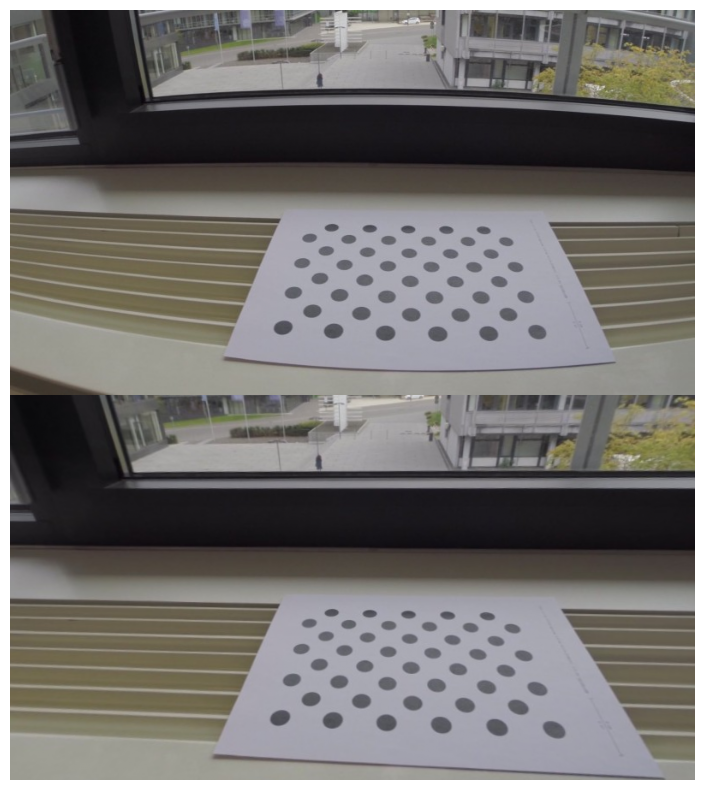

In [18]:

def undistort_image(image, camera_matrix, dist_coeffs):

    height, width = image.shape[:2]
    channels = 1 if image.ndim == 2 else image.shape[2]
    output_image = np.zeros_like(image)

    # Helper functions to check coordinate bounds
    is_valid_x = lambda x_coord: 0 <= x_coord < width
    is_valid_y = lambda y_coord: 0 <= y_coord < height

    for target_y in range(height):          # Target image y-coordinate
        for target_x in range(width):       # Target image x-coordinate
            source_x, source_y = undistort_point(target_x, target_y,
                                               camera_matrix,
                                               dist_coeffs)  # Source image location (floating point)

            # Integer coordinates for bilinear interpolation
            source_x_floor, source_y_floor = int(np.floor(source_x)), int(np.floor(source_y))
            source_x_ceil, source_y_ceil = source_x_floor + 1, source_y_floor + 1

            # Skip if interpolation window extends beyond image boundaries
            if not (is_valid_x(source_x_floor) and is_valid_x(source_x_ceil) and 
                   is_valid_y(source_y_floor) and is_valid_y(source_y_ceil)):
                continue

            x_fraction, y_fraction = source_x - source_x_floor, source_y - source_y_floor  # Interpolation weights

            # Extract pixel values from source image
            if channels == 1:  # Grayscale image
                top_left = image[source_y_floor, source_x_floor]
                top_right = image[source_y_floor, source_x_ceil]
                bottom_left = image[source_y_ceil, source_x_floor]
                bottom_right = image[source_y_ceil, source_x_ceil]
            else:             # Colour image
                top_left = image[source_y_floor, source_x_floor, :]
                top_right = image[source_y_floor, source_x_ceil, :]
                bottom_left = image[source_y_ceil, source_x_floor, :]
                bottom_right = image[source_y_ceil, source_x_ceil, :]

            # Perform bilinear interpolation
            interpolated_value = ((1 - x_fraction) * (1 - y_fraction) * top_left +
                                x_fraction * (1 - y_fraction) * top_right +
                                (1 - x_fraction) * y_fraction * bottom_left +
                                x_fraction * y_fraction * bottom_right)

            if channels == 1:
                output_image[target_y, target_x] = interpolated_value
            else:
                output_image[target_y, target_x, :] = interpolated_value

    return output_image

## The intrinsic camera matrix and lens undistortion coefficients for the test image.
source = plt.imread('window.jpg') / 255.
camera_matrix = np.array([[474.53, 0, 405.96], [0, 474.53, 217.81], [0, 0, 1]])
dist_coeffs = np.array([-0.27194, 0.11517, -0.029859])

## Visualise input (top) and undistorted output (bottom).
target_unvectorised = undistort_image(source, camera_matrix, dist_coeffs)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.vstack([source, target_unvectorised]))
plt.axis("off");

<span style="color:red"> **For you to do:** </span>

**c) Implement fast image undistortion using vectorisation, without any for-loops. Your function should run in less than 3 seconds. [15 marks]**

Remember that the vectorised version of your undistortion function must be functionally identical to the original. This means the function must also perform bilinear interpolation.

This is the advanced question of the assignment, so it will be marked stricter than 4b in terms of correctness of output and performance, with partial credit awarded only rarely. Watch out for hidden for-loops in your implementation.

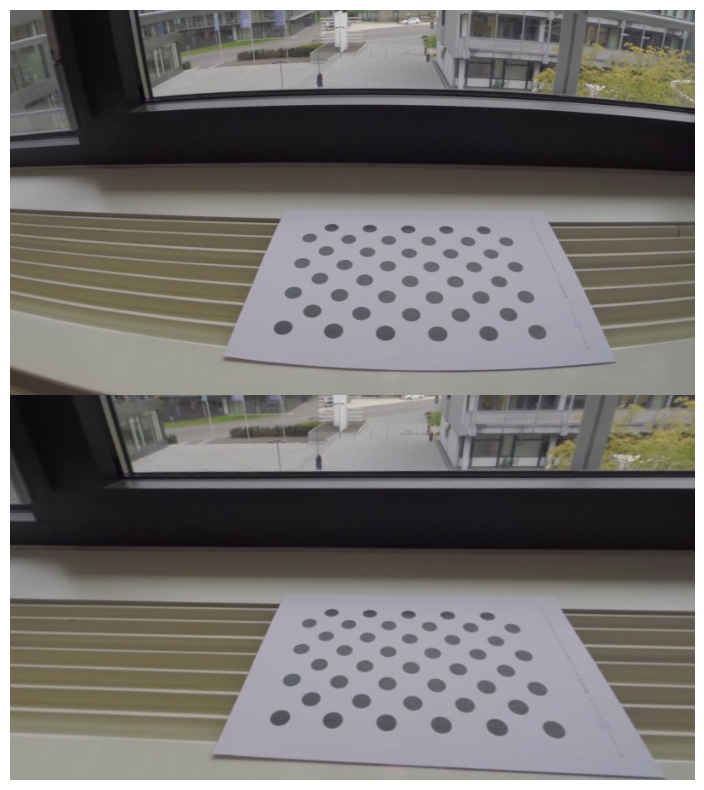

In [20]:
def undistort_image_vectorised(image, camera_matrix, dist_coeffs):
    height, width = image.shape[:2]
    channels = 1 if image.ndim == 2 else image.shape[2]

    # Create coordinate grid for target pixels
    # -----------------------------------------
    target_x, target_y = np.meshgrid(np.arange(width), np.arange(height))

    # Apply radial distortion model to transform coordinates
    # -------------------------------------------------------
    focal_x, focal_y = camera_matrix[0, 0], camera_matrix[1, 1]
    principal_x, principal_y = camera_matrix[0, 2], camera_matrix[1, 2]
    radial_k1, radial_k2, radial_k3 = dist_coeffs

    normalised_x = (target_x - principal_x) / focal_x
    normalised_y = (target_y - principal_y) / focal_y
    radius_squared = normalised_x * normalised_x + normalised_y * normalised_y
    radial_factor = 1.0 + radial_k1 * radius_squared + radial_k2 * radius_squared**2 + radial_k3 * radius_squared**3
    source_x = focal_x * (normalised_x * radial_factor) + principal_x
    source_y = focal_y * (normalised_y * radial_factor) + principal_y


    # Calculate interpolation weights and neighbour indices
    # ------------------------------------------------------
    source_x_floor = np.floor(source_x).astype(np.int32)
    source_y_floor = np.floor(source_y).astype(np.int32)
    source_x_ceil = source_x_floor + 1
    source_y_ceil = source_y_floor + 1

    valid_pixels = (source_x_floor >= 0) & (source_x_ceil < width) & (source_y_floor >= 0) & (source_y_ceil < height)

    source_x_floor_clipped = np.clip(source_x_floor, 0, width - 1)
    source_x_ceil_clipped = np.clip(source_x_ceil, 0, width - 1)
    source_y_floor_clipped = np.clip(source_y_floor, 0, height - 1)
    source_y_ceil_clipped = np.clip(source_y_ceil, 0, height - 1)

    x_fraction = (source_x - source_x_floor)[..., None]
    y_fraction = (source_y - source_y_floor)[..., None]

    # Extract neighbouring pixels using advanced indexing
    # ---------------------------------------------------
    idx_top_left = source_y_floor_clipped * width + source_x_floor_clipped
    idx_top_right = source_y_floor_clipped * width + source_x_ceil_clipped
    idx_bottom_left = source_y_ceil_clipped * width + source_x_floor_clipped
    idx_bottom_right = source_y_ceil_clipped * width + source_x_ceil_clipped

    flat_image = image.reshape(-1, channels) if channels > 1 else image.reshape(-1, 1)
    pixel_top_left = flat_image[idx_top_left.ravel()].reshape(height, width, channels)
    pixel_top_right = flat_image[idx_top_right.ravel()].reshape(height, width, channels)
    pixel_bottom_left = flat_image[idx_bottom_left.ravel()].reshape(height, width, channels)
    pixel_bottom_right = flat_image[idx_bottom_right.ravel()].reshape(height, width, channels)

    # Perform bilinear interpolation
    # ------------------------------
    weight_top_left = (1 - x_fraction) * (1 - y_fraction)
    weight_top_right = x_fraction * (1 - y_fraction)
    weight_bottom_left = (1 - x_fraction) * y_fraction
    weight_bottom_right = x_fraction * y_fraction

    interpolated_image = (weight_top_left * pixel_top_left + 
                         weight_top_right * pixel_top_right + 
                         weight_bottom_left * pixel_bottom_left + 
                         weight_bottom_right * pixel_bottom_right)

    # Handle invalid pixels and output format
    # ---------------------------------------
    if channels == 1:
        interpolated_image = interpolated_image.squeeze(-1)
    interpolated_image[~valid_pixels] = 0

    return interpolated_image.astype(image.dtype)

# Visualise input (top) and undistorted output (bottom).
target_vectorised = undistort_image_vectorised(source, camera_matrix, dist_coeffs)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.vstack([source, target_vectorised]))
plt.axis("off");

<span style="color:red"> **For you to do:** </span>

**d) Show that both the original and the vectorised implementations produce the same result by running the cell below. [10 marks]**

Partial credit will be awarded if the outputs are consistent with each other but not completely correct. If the output is completely wrong given the task (e.g., not undistorted), no credit will be awarded.

Note that for consistent outputs the difference below will be very small (say, order of e-15) but not completely zero.

If you find a discrepancy between the outputs, go back and debug the relevant implementation.

In [21]:
difference = np.sum(np.abs(target_unvectorised - target_vectorised))
print(difference)

3.4833247397614286e-15
